# Getting Started Guide

This notebook goes through the "Example Scripts Getting Started Guide" you will find on the TNG data release webpage, based on having local access to the data through the JupyterLab interface. You can run through this notebook to gain some familiarity with basic data access. To do so, you should copy it from this 'examples' folder to your home directory, so that the paths are correct.

Since we are already working on a server with direct access to the data, there is no need to download any files.

## Group Catalogs

Import the example scripts (they have already automatically been added to the PYTHONPATH)

In [4]:
import illustris_python as il
import numpy as np

Define the base path for the data, i.e. choose the simulation we want to work with. The "getting started" guide suggests to use TNG100-3 (the lowest resolution version of TNG100), since it needs to be downloaded. But let's just use TNG100-1 (the highest resolution version of TNG100) directly.

In [5]:
basePath = '../sims.TNG/TNG100-1/output/'

Let's load a few fields from the $z=0$ group catalog. In particular, the total masses (`SubhaloMass`) and star formation rate within twice the stellar half mass radius (`SubhaloSFRinRad`) of all the Subfind subhalos.

In [6]:
fields = ['SubhaloMass','SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=fields)

In [7]:
subhalos.keys()

dict_keys(['count', 'SubhaloMass', 'SubhaloSFRinRad'])

In [8]:
subhalos['SubhaloMass'].shape

(4371211,)

Inspecting the return, we see it is a dict/hash/struct with a key count indicating that there are about 4.4 million total subhalos. Each requested field is returned as a numeric array with a key name equal to its field name in the group catalog.

---

Let's make a simple scatterplot of the relation (note the unit conversions for mass, while SFR is in $M_\odot \rm{yr}^{-1}$ already in the snapshots).

In [9]:
import matplotlib.pyplot as plt

In [10]:
mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.6774

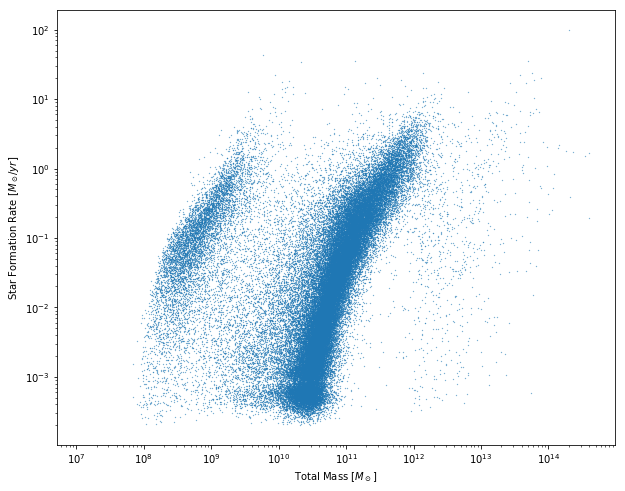

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(mass_msun, subhalos['SubhaloSFRinRad'], '.', markersize=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Total Mass [$M_\odot$]')
ax.set_ylabel('Star Formation Rate [$M_\odot / yr$]');

Not quite what we were expecting perhaps. Let us load the stellar masses of these subhalos, and plot $\dot{M}_\star/M_\star$ (sSFR) vs $M_\star$ rather than $\dot{M}_\star$ vs $M_{\rm sub}$.

In [12]:
mass_type_code = il.groupcat.loadSubhalos(basePath, 99, fields=['SubhaloMassInRadType'])

In [13]:
mass_mstar_msun = mass_type_code[:,4] * 1e10 / 0.6774
with np.errstate(invalid='ignore'):
    # avoid "RuntimeWarning: invalid value encountered in true_divide" since mass_mstar_msun contains zeros
    ssfr = subhalos['SubhaloSFRinRad'] / mass_mstar_msun

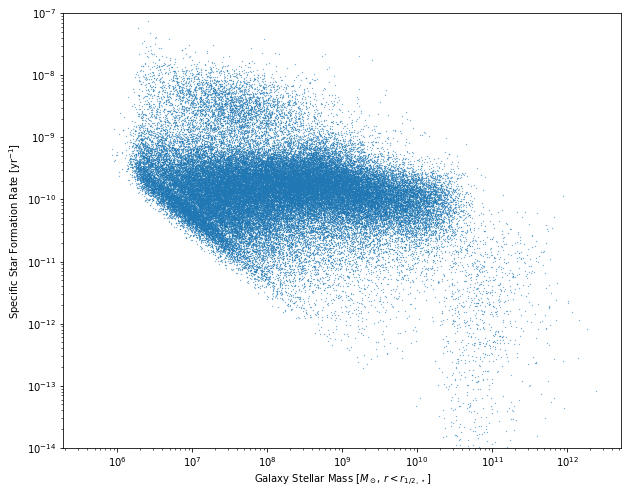

In [14]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(mass_mstar_msun, ssfr, '.', markersize=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-14,1e-7])
ax.set_xlabel('Galaxy Stellar Mass [$M_\odot$, $r < r_{\\rm 1/2,\star}$]')
ax.set_ylabel('Specific Star Formation Rate [yr$^{-1}$]');

The clear locus at roughly constant sSFR $\simeq 10^{-10}$ yr$^{-1}$ is the star formation main sequence (MS) of galaxies at redshift zero. We also see outliers below this main population (i.e. quenched galaxies). 

It is always good to be cautious using values from the group catalogs directly, and important to realize how they are defined and measured. For example, the diagonal line at the lower-left represents a minimum "resolvable" SFR as a function mass. Galaxies below this value will have $\rm{SFR} == 0$, because they have absolutely no star-forming gas. Since we have used a log-log plot, however, we have accidentally excluded these systems. Let's add them back, in such a way that we can keep track of them.

In [15]:
w = np.where(ssfr == 0.0)
print('Number of SFR == 0 subhalos (that have nonzero stellar mass): %d' % len(w[0]))

Number of SFR == 0 subhalos (that have nonzero stellar mass): 144353


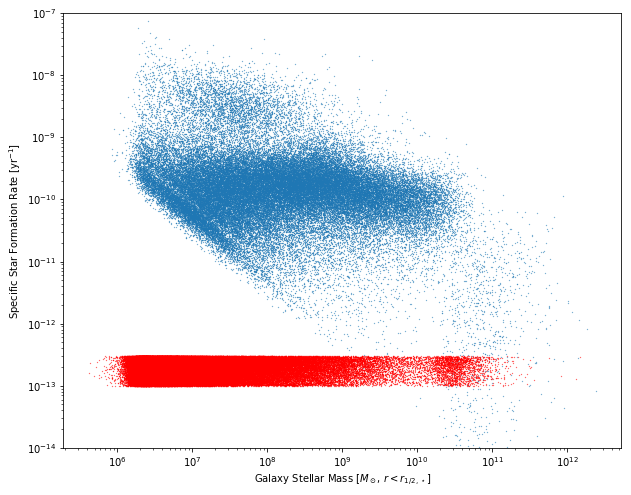

In [16]:
dummy_ssfr_vals = np.random.uniform(low=1e-13, high=3e-13, size=len(w[0]))
ax.plot(mass_mstar_msun[w], dummy_ssfr_vals, '.', color='red', markersize=0.5)
fig

There are a sizeable number of (likely central) galaxies at the high mass end (i.e. $M_\star \gtrsim 10^{10} M_\odot$) with zero SFR, which would be important to include in any analysis of quenching. There are also a large number of zero-SFR systems below this mass, which are predominantly satellites and splashback galaxies.

---

While we have all the stellar masses loaded, let's make a quick stellar mass function (SMF).
First let's define a helper function to calculate the histogram.

In [33]:
def running_histogram(X, binSize):
    """ Create a adaptive histogram of a (x) point set using some given binsize. """
    minVal = np.nanmin( X[X != 0.0] )

    nBins = int( (np.nanmax(X)-minVal) / binSize )
    bins = np.linspace(minVal,np.nanmax(X), nBins)
    delta = bins[1]-bins[0]

    running_h   = []
    bin_centers = []

    for i, bin in enumerate(bins):
        binMax = bin + delta
        with np.errstate(invalid='ignore'):
            w = np.where((X >= bin) & (X < binMax))

        if len(w[0]):
            running_h.append( len(w[0]) )
            bin_centers.append( np.nanmedian(X[w]) )

    return np.array(bin_centers), np.array(running_h)

Now histogram the stellar masses and normalize by the comoving volume.

In [44]:
binSize = 0.15 # dex

w = np.where(mass_mstar_msun > 0) # only subhalos with nonzero stellar mass
mass_mstar_logmsun = np.log10(mass_mstar_msun[w])

xm, ym = running_histogram(mass_mstar_logmsun, binSize=binSize)

In [45]:
# load header from the group catalog
header = il.groupcat.loadHeader(basePath, 99)
norm_factor = (header['BoxSize']/1000)**3 * binSize

ym = ym / norm_factor

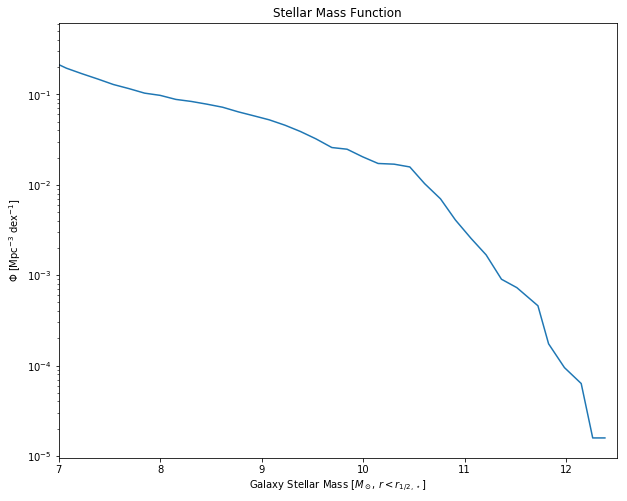

In [47]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(xm, ym, '-')
ax.set_yscale('log')
ax.set_xlim([7.0,12.5])
ax.set_title('Stellar Mass Function')
ax.set_xlabel('Galaxy Stellar Mass [$M_\odot$, $r < r_{\\rm 1/2,\star}$]')
ax.set_ylabel('$\Phi$ [Mpc$^{-3}$ dex$^{-1}$]');

---

Keep in mind an important point! Up until now, we have been plotting all subhalos in the group catalog -- that is, both "centrals" and "satellites". It is often useful to consider these two separately.

Let's get a list of "primary" (central) subhalo IDs, by using the `GroupFirstSub` values of the FoF halos/groups.

In [49]:
GroupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])

In [56]:
GroupFirstSub.dtype, GroupFirstSub.shape

(dtype('int32'), (6291349,))

In [57]:
w = np.where(GroupFirstSub >= 0) # value of -1 indicates no subhalo in this group
central_subhalo_ids = GroupFirstSub[w]

In [58]:
len(central_subhalo_ids)

3430706

In [59]:
central_subhalo_ids[0:10]

array([    0, 17185, 31342, 41582, 52618, 60731, 69507, 76086, 83280, 88663], dtype=int32)

The gap between the first and second subhalo IDs (or indices, we use these terms interchangably) of 17185 subhalos is therefore occupied by all the satellites of the most massive halo in the box. Let's verify that this is true.

In [60]:
halo_0 = il.groupcat.loadSingle(basePath,99,haloID=0)

In [62]:
halo_0['GroupNsubs']

17185

For the 5 most massive central subhalos, let's load all their fields from the group catalog and print a gas fraction (gas mass over total baryonic mass) in the stellar half mass radius.

In [63]:
for i in range(5):
    sub = il.groupcat.loadSingle(basePath, 99, subhaloID=central_subhalo_ids[i])
    gas_mass = sub['SubhaloMassInHalfRadType'][0] # code units
    stars_mass = sub['SubhaloMassInHalfRadType'][4] # code units
    fgas = gas_mass / (gas_mass + stars_mass)
    print(i, central_subhalo_ids[i], fgas)

0 0 0.0973186
1 17185 0.243193
2 31342 0.154365
3 41582 0.148347
4 52618 0.0863


## Merger Trees

Let's explore how we can find the time evolution of a given subhalo of interest, using the `SubLink` merger tree.

For the 100th through 104th most massive primaries, extract the total mass, Subfind ID, and snapshot along the main progenitor branch. Plot the mass histories.

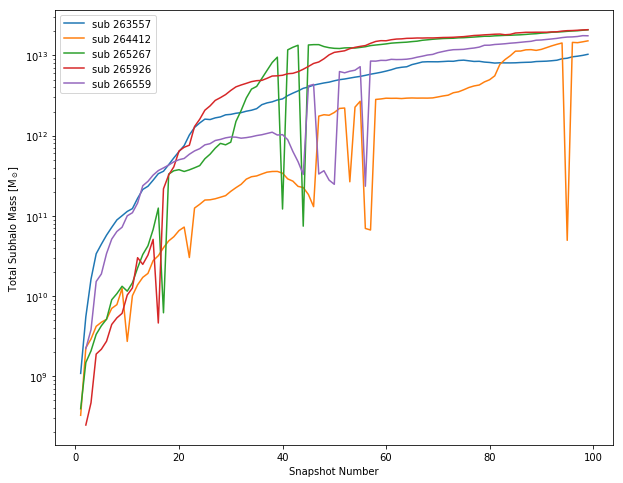

In [68]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

fields = ['SubhaloMass','SubfindID','SnapNum']
start = 99
for i in range(start, start+5):
    tree = il.sublink.loadTree(basePath, 99, central_subhalo_ids[i], fields=fields, onlyMPB=True)
    mass_msun = tree['SubhaloMass'] * 1e10 / 0.6774
    ax.plot(tree['SnapNum'], mass_msun, '-', label='sub %d' % central_subhalo_ids[i])
    
ax.set_yscale('log')
ax.set_xlabel('Snapshot Number')
ax.set_ylabel('Total Subhalo Mass [M$_\odot$]')
ax.legend();

Note that the single-snapshot dips seen in some of the curves indicate the 'subhalo switching problem', where the downward trend in mass followed by the sudden increase is a signature of confusing the main progenitor branch (MPB) during major merger events. For a scientific analysis of mass assembly/accretion histories, one would want to process these curves further.

---
As an aside, you can use part of the web API functionality, to retrieve a visualization of the full merger tree of the first subhalo above.

The URL is: http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/263557/sublink/tree.png

More information and documentation on the API is available: http://www.tng-project.org/data/docs/api/

---

Finally, the example scripts code includes one semi-complex example code `numMergers()` which walks through the tree to determine the number of past mergers of a given subhalo, above some mass ratio threshold. Here, the mass ratio is defined as the ratio of the maximum past stellar mass of the two progenitors.

For the same five halos as above, count the number of major mergers (mass ratio > 1/4).

In [71]:
ratio = 1/4

# the following fields are required for the walk and the mass ratio analysis
fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType']

for i in range(start, start+5):
    tree = il.sublink.loadTree(basePath, 99, central_subhalo_ids[i], fields=fields)
    numMergers = il.sublink.numMergers(tree,minMassRatio=ratio)
    print(i, central_subhalo_ids[i], ' num major mergers = ', numMergers)

99 263557  num major mergers =  2
100 264412  num major mergers =  6
101 265267  num major mergers =  5
102 265926  num major mergers =  4
103 266559  num major mergers =  3


## Snapshot Data

We can also work directly with the particle/cell data in the snapshots (gas, stars, dark matter, and black holes).

First, as a rule of thumb, keep in mind that loading *all* particles/cells for one snapshot will generally require too much memory.

For a quick estimate, remember that TNG100-1 has $\sim 1820^3$ resolution elements. To load a single float32 (4-bytes per particle/cell) field such as `Masses` then requires $4 \times 1820^3 / 1024^3 \simeq 22.5 \rm{GB}$ of memory. Loading a single float64 (or int64 field, such as `ParticleIDs`) will then require about 45 GB of memory, and loading the full `Coordinates` (double precision) will require about 135 GB of memory.

As a starting point, the JupyterLab instance is limited to 10 GB of memory usage.

---

For convenience let's switch to TNG100-3 and load the full details on gas positions and masses. We can use these to create the simplest type of visualization: a (weighted) 2D histogram, showing the large-scale structure of the box.

In [72]:
basePath = 'sims.TNG/TNG100-3/output/'

In [73]:
gas = il.snapshot.loadSubset(basePath, 99, 'gas', fields=['Masses','Coordinates'])

In [74]:
from scipy.stats import binned_statistic_2d

In [90]:
x = gas['Coordinates'][:,0]
y = gas['Coordinates'][:,1]
weights = gas['Masses']
nPixels = [600,600]
minMax = [0, header['BoxSize']]

grid, _, _, _ = binned_statistic_2d(x, y, weights, 'sum', bins=nPixels, range=[minMax,minMax])

Our `grid` now contains the sum of gas mass per pixel (projected along the line of sight, through the whole box depth) in code mass units. We can convert this to solar masses, then normalize by the pixel area, to obtain $M_\odot / \rm{kpc}^2$.

In [102]:
pxSize = header['BoxSize'] / nPixels[0] # code units
pxSize_kpc = pxSize * header['Time'] / header['HubbleParam']
pxArea = pxSize_kpc**2

grid_log_msun_per_kpc2 = np.log10(grid * 1e10 / header['HubbleParam'] / pxArea)

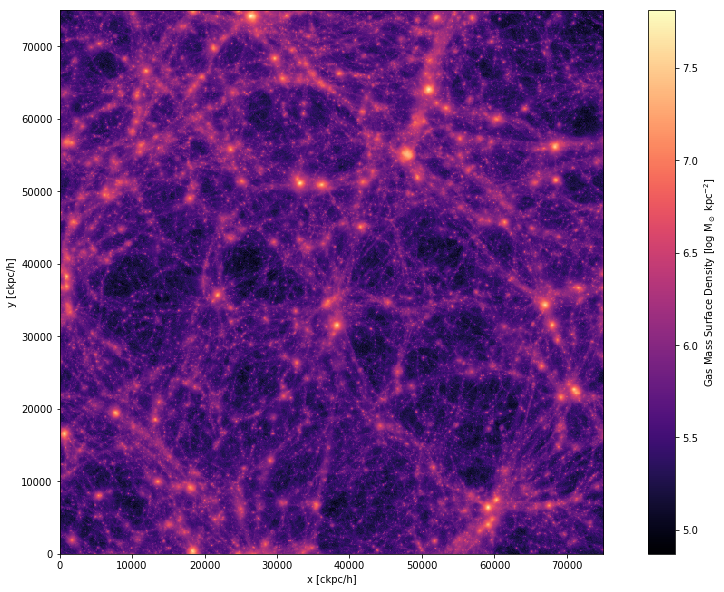

In [104]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

extent = [0, header['BoxSize'], 0, header['BoxSize']]
plt.imshow(grid_log_msun_per_kpc2, extent=extent, cmap='magma', aspect=nPixels[1]/nPixels[0])
ax.autoscale(False)
ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')
plt.colorbar(label='Gas Mass Surface Density [log M$_\odot$ kpc$^{-2}$]');

---

Instead of loading the entire box, let's load just the member particles of a particular halo (we will take halo ID 500 at random). First, switch back to TNG100-1.

In [105]:
basePath = 'sims.TNG/TNG100-1/output/'

In [108]:
haloID = 500
fields = ['Masses','Coordinates','InternalEnergy','ElectronAbundance']
gas = il.snapshot.loadHalo(basePath, 99, haloID, 'gas', fields=fields)

In [109]:
gas['count'], gas.keys()

(134814,
 dict_keys(['count', 'Masses', 'Coordinates', 'InternalEnergy', 'ElectronAbundance']))

There are about ~135k gas cells in this FoF halo. Note we have also loaded the two fields necessary to compute gas temperature, so let's define a helper function to do that now.

In [115]:
def utherm_ne_to_temp(utherm, nelec):
    """ Convert the InternalEnergy and ElectronAbundance of gas cells to temperature in [log K]. """
    hydrogen_massfrac = 0.76 # approximate
    mass_proton = 1.672622e-24 # cgs
    gamma = 5/3
    boltzmann = 1.380650e-16 # cgs (erg/K)

    # unit system
    UnitLength_in_cm = 3.085678e21   # 1.0 kpc
    UnitMass_in_g = 1.989e43 # 1.0e10 solar masses
    UnitVelocity_in_cm_per_s = 1.0e5 # 1 km/sec

    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitEnergy_in_cgs = UnitMass_in_g * UnitLength_in_cm**2.0 / UnitTime_in_s**2.0

    # calculate mean molecular weight
    meanmolwt = 4.0/(1.0 + 3.0 * hydrogen_massfrac + 4.0* hydrogen_massfrac * nelec)
    meanmolwt *= mass_proton

    # calculate temperature (K)
    temp = utherm * (gamma-1.0) / boltzmann * UnitEnergy_in_cgs / UnitMass_in_g * meanmolwt
    temp = np.log10(temp)

    return temp.astype('float32')

In [116]:
temp = utherm_ne_to_temp(gas['InternalEnergy'], gas['ElectronAbundance'])

Let's plot a simple 1D histogram of temperatures as a sanity check.

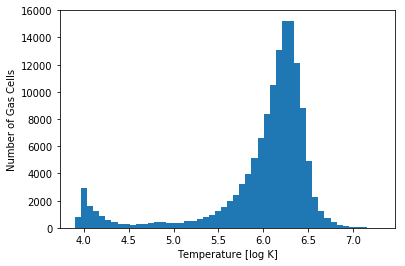

In [121]:
plt.hist(temp, 50);
plt.xlabel('Temperature [log K]');
plt.ylabel('Number of Gas Cells');

In [124]:
halo = il.groupcat.loadSingle(basePath, 99, haloID=haloID)
halo_m200_logmsun = np.log10(halo['Group_M_Crit200'] * 1e10 / 0.6774)
print(halo_m200_logmsun)

12.6038096568


With a total mass of $10^{12.6}$ M$_\odot$ the halo has a virial temperature of $T_{\rm vir} \simeq 10^{6.2}$ K, around which the temperatures are clustered.

Let's create another simple visualization: a mean 2D histogram of a quantity other than mass.

In [129]:
x = gas['Coordinates'][:,0] - halo['GroupPos'][0]
y = gas['Coordinates'][:,1] - halo['GroupPos'][1]

nPixels = [300,300]
minMax = [-500, 500] # code units, relative to the halo center

grid_temp, _, _, _ = binned_statistic_2d(x, y, temp, 'mean', bins=nPixels, range=[minMax,minMax])

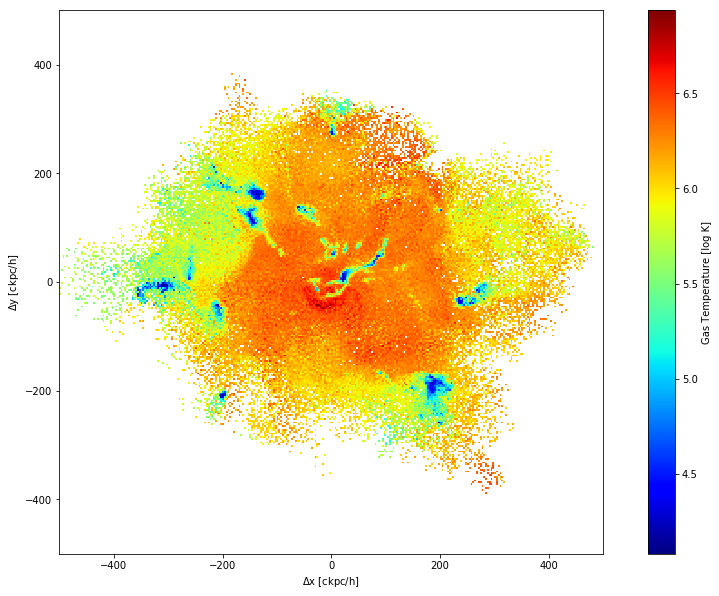

In [130]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)

extent = [minMax[0], minMax[1], minMax[0], minMax[1]]
plt.imshow(grid_temp, extent=extent, cmap='jet', aspect=nPixels[1]/nPixels[0])
ax.autoscale(False)
ax.set_xlabel('$\Delta$x [ckpc/h]')
ax.set_ylabel('$\Delta$y [ckpc/h]')
plt.colorbar(label='Gas Temperature [log K]');

Note: we have ignored the periodic boundary conditions of the box. If this object had been near the edges of the box, its particle could have "wrapped" around an edge, and this should be corrected as a general rule when computing relative distances, as $x$ and $y$ above.

## What next?

Although it's possible that you could answer a question or complete an analysis task using the group catalog data alone, a more typical workflow might involve:

* Select halos/subhalos/galaxies of interest using existing group catalog data (i.e. halo mass, stellar mass).
* For every object of interest, load its particle-level data and compute one or more custom quantities.
* Save such "supplementary catalogs" of post-processed quantities.
* Combine this data with other data sets to examine trends and relationships.